### Загрузим необходимые библиотеки

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 13.6 MB/s eta 0:00:00


In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 18.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import pmdarima as pm
from arch import arch_model

### Загрузим данные и проанализируем их

In [41]:
boston = pd.read_csv('monthly-boston-armed-robberies-j.csv')
boston.head()

,Month,Count
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


In [42]:
#функция теста Дики-Фуллера
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print(dftest[1])

In [43]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
0.994277563805723


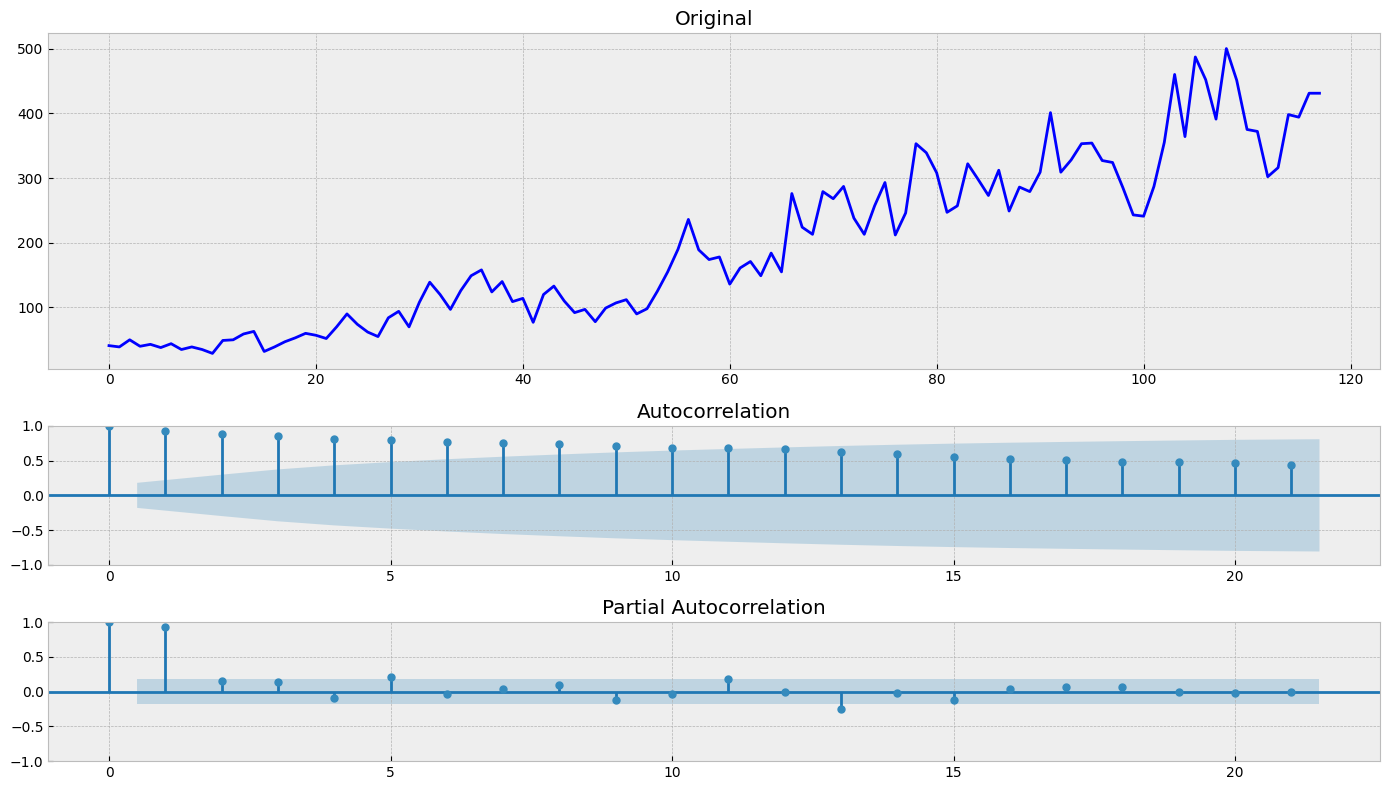

In [44]:
tsplot(boston['Count'])

Временной ряд нестационарен и в нем наблюдается восходящий тренд

### Приведем временной ряд к стационарному

In [48]:
#Нормализуем дисперсию
ts = boxcox(boston['Count'], 0)
#Дифференцируем для устранения тренда
ts = np.diff(ts)

Results of Dickey-Fuller Test:
2.3786024417437596e-11


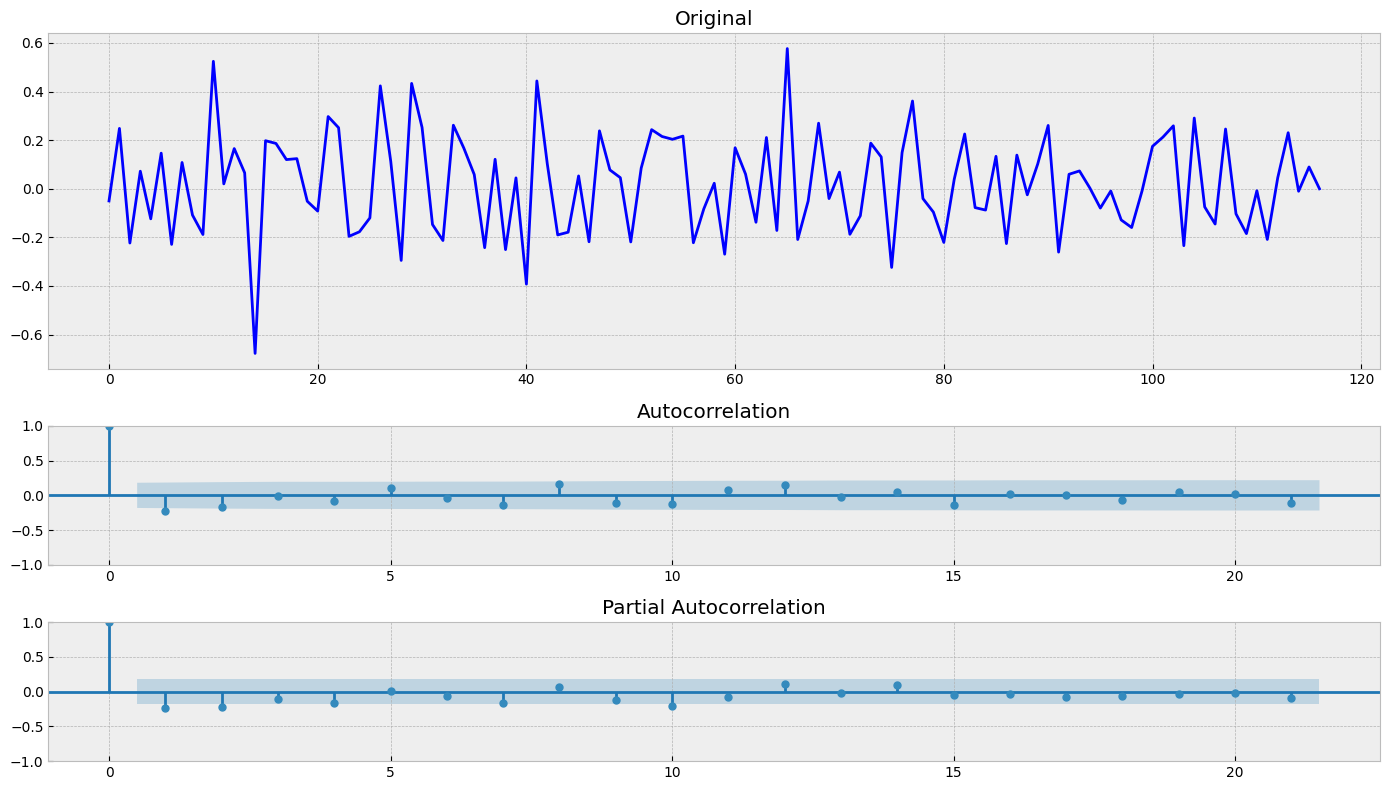

In [49]:
tsplot(ts)

### Делим данные на тренировочные и тестовые

In [50]:
sales.shape

(118, 2)

In [51]:
train, test = ts[:100], ts[100:]

### Используем автоподбор параметров модели ARIMA

In [23]:
auto_model = pm.auto_arima(train,
                           start_p=0, max_p=5,
                           start_q=0, max_q=5,
                           d=None, max_d=2,
                           m=12,
                           trace=True,
                           error_action ='ignore',
                           suppress_warnings = True,
                           stepwise = True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-23.022, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-26.618, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-31.579, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-24.323, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-31.471, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-29.817, Time=0.50 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-31.845, Time=0.16 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=-30.498, Time=1.41 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-22.547, Time=0.12 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-33.953, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-34.786, Time=0.18 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-3

Построим модель GARCH, используя найденные параметры

In [24]:
am = arch_model(train, p=1, o=0, q=1, vol='GARCH', dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: -14.449681013961106
Iteration:     10,   Func. Count:     68,   Neg. LLF: -14.80567506752855
Iteration:     15,   Func. Count:     98,   Neg. LLF: -14.858912408376993
Iteration:     20,   Func. Count:    132,   Neg. LLF: -14.861181561325212
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14.861184214105648
            Iterations: 20
            Function evaluations: 142
            Gradient evaluations: 20
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                14.8612
Distribution:      Standardized Student's t   AIC:                          -19.7224
Method:                  Maximum Likelihood   BIC:                  

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04469. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


### Визуализируем график остатков

Results of Dickey-Fuller Test:
6.444814271719808e-17


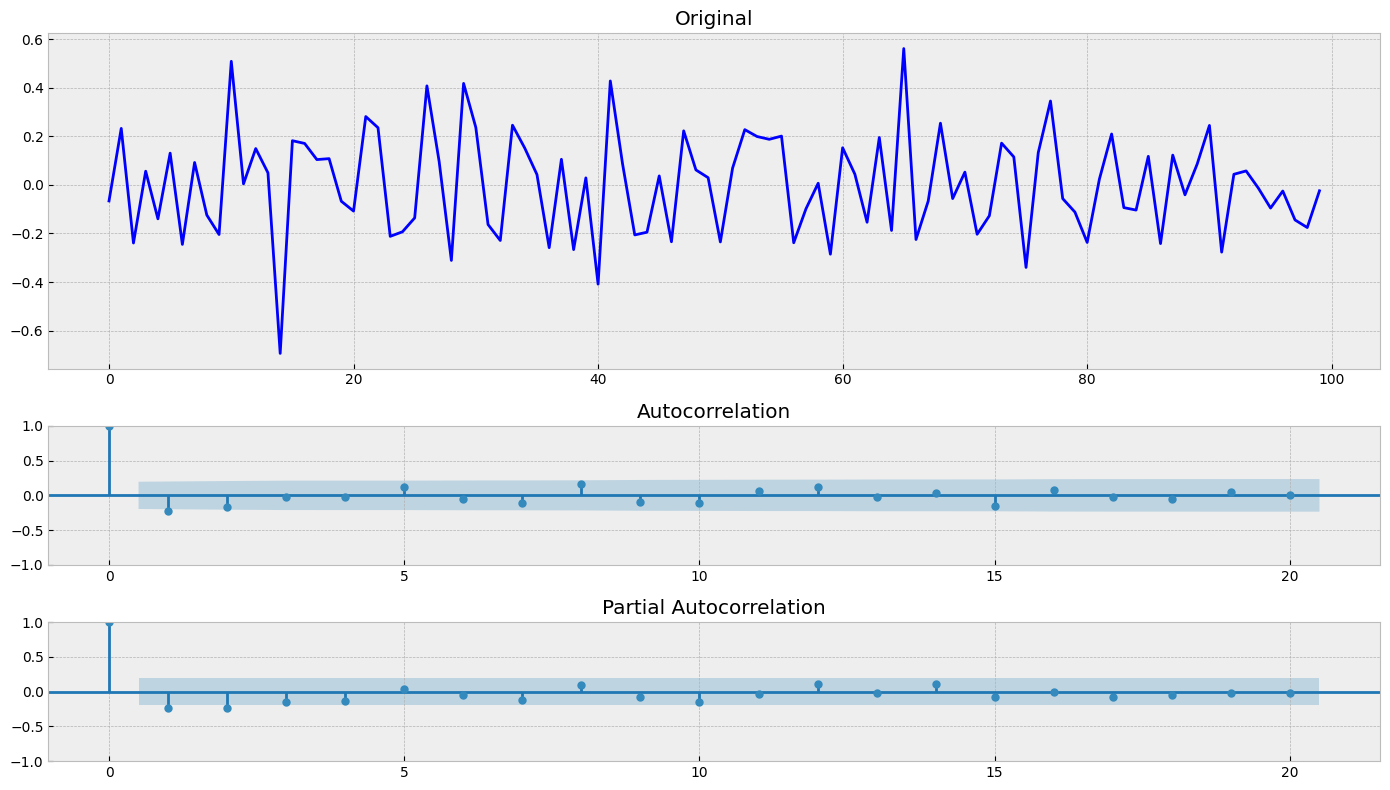

In [25]:
tsplot(res.resid)

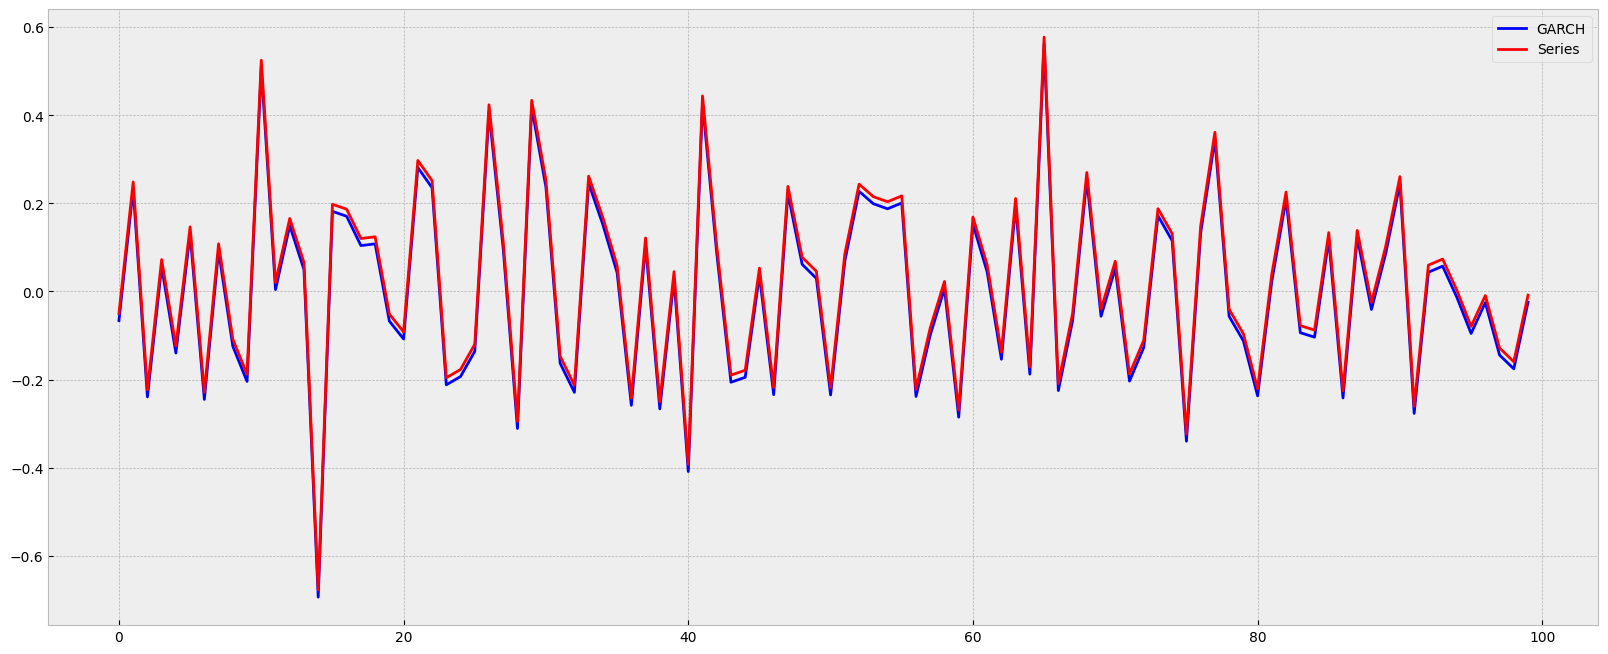

In [54]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    plt.plot(res.resid, color='blue', label='GARCH')
    plt.plot(ts[:100], color='red', label='Series')
    plt.legend()

### Предскажем значения с помощью полученной модели и сравним их с тестовыми

In [55]:
pred = res.forecast(horizon=len(test))

In [56]:
forecast = train.copy()
forecast = np.concatenate((forecast, pred.variance.values[-1, :]))

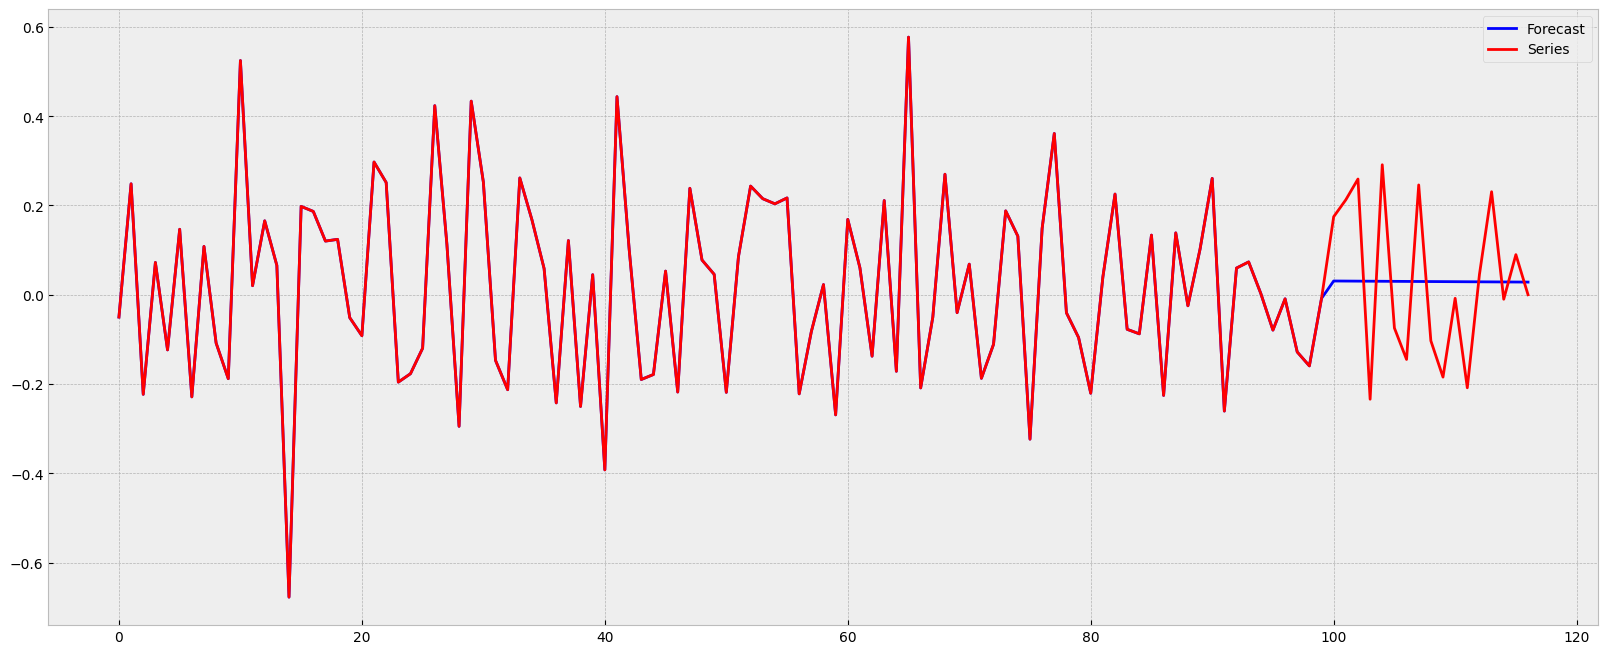

In [57]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    plt.plot(forecast, color='blue', label='Forecast')
    plt.plot(ts, color='red', label='Series')
    plt.legend()

Несмотря на близость значений модели GARCH с тренировочными данными, припредсказании тестовых значений модель выходит на плато, что не позволяет использовать ее для предсказания дисперсии данного временного ряда